## package import

In [1]:

#import libraries
import cytoflow as flow

# mpl.use('TkAgg')
from itertools import product
import os
%matplotlib inline
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import sklearn
import sys
from scipy.special import factorial
import re
import statistics as stats
import itertools
from matplotlib.lines import Line2D
from pandas.api.types import CategoricalDtype
from scipy.stats import spearmanr

In [2]:
mpl.rcParams['font.sans-serif'] = "Helvetica Neue"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42 # make labels editable in pdf

mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

sns.set_style("ticks")
sns.set_context("talk", font_scale = 0.5)
mpl.rc('figure', dpi = 160)

## data import

In [3]:
# list the directories where you want to search for FCS files
ZE5rawdatapath = '/Users/tfuji/Library/CloudStorage/GoogleDrive-tfuji@stanford.edu/My Drive/flow_analysis/rawdata_dCas12a/'
dataDir = ['timecourse/']

separator_list = '_posttfxday|_rep' # modifly the next cell accordingly

In [4]:
#the following is copied directly from one of Connor's notebooks:
def find_tubes(fcsList, path, item):
    itempath = os.path.join(path, item)
    if os.path.isdir(itempath):
        for subitem in os.listdir(itempath):
            find_tubes(fcsList, itempath, subitem)
    elif '.fcs' in itempath:
        fcsList.append(itempath)
    return fcsList

fcsList = []

# find FCS files in the directories specified above
for path in dataDir:
    dataDirList = os.listdir(ZE5rawdatapath+path)
    for dirs in dataDirList:
        fcsList = find_tubes(fcsList, ZE5rawdatapath+path, dirs)

tubeList = []
for file in fcsList:
    file_elements = re.split(separator_list,file.split('/')[-1].split(' ')[1][:-4]) # remove well and .fcs, then split based on underscores
    target = file_elements[0]
    rep = int(file_elements[2])
    day = int(file_elements[1])
    tubeList.extend([flow.Tube(conditions = {'day':day,
                                        'target':target,
                                        'rep':rep,},
                          file = file,
                          conditions_list = ["day", "target", "rep"])])

In [5]:
#import tubes
op_0 = flow.ImportOp(conditions = {'day':'int', 'target':'category', 'rep':'int'},
                tubes = tubeList, ignore_v=['FSC 488/10-A','FSC 488/10-H','FSC 488/10-W','SSC 488/10-A','SSC 488/10-W','SSC 488/10-H','mCitrine-A','mCitrine-W','mCitrine-H'])
ex_0 = op_0.apply()

/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel TLSW, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel TMSW, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel Event Info, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel FSC 488/10-H, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400

## set gating

In [6]:
#draw a polygon gate around live cells
op_1 = flow.PolygonOp(
    xchannel='FSC 488/10-A',
    vertices=[(3e8, 7e8),(0.75e9, 1.5e9),(1.3e9, 1.6e9),(1.4e9, 1e9),(0.9e9, 2.5e8),(2.5e8, 2.5e8)],
    ychannel='SSC 488/10-A',
    name='P1')

ex_1 = op_1.apply(ex_0)

# # view gate
# op_1.default_view(
#     yscale='linear',
#     xscale='linear',
#     huefacet='target').plot(ex_1, alpha = .01,
#                           xlim=(2e8, math.pow(2,31)), # originally 1e8 for lower end, 2^31 higher end
#                           ylim=(1e7, math.pow(2,31)), # originally 1e6 for lower end, 2^31 higher end
#                           height = 4,
#                           aspect = 1,)

P1_pos = len(ex_1.data[ex_1.data['P1']==True])
P1_neg = len(ex_1.data[ex_1.data['P1']==False])
P1_percent = str(round(100*P1_pos/(P1_pos + P1_neg), 1)) + '%'
print('Percent of events in P1 gate: %s' % P1_percent)

Percent of events in P1 gate: 90.9%


In [7]:
# set a polygon gate for single cells 'P2'
op_2 = flow.PolygonOp(name='P2',
                 xchannel='SSC 488/10-H',
                 ychannel='SSC 488/10-A',
                 vertices=[(1.2e8, 2.0e8),
                           (9.0e8, 1.5e9),
                           (11.3e8, 1.5e9),
                           (3.5e8, 2.0e8)])
ex_2 = op_2.apply(ex_1)

# # view gate
# op_2.default_view(xscale = 'linear',
#                   yscale = 'linear',
#                   huefacet = 'rep',
#                   subset='(P1 == True)').plot(ex_2, alpha = 0.01, xlim=(0, 1.2e9), ylim=(0, 1.6e9))

# Check that most cells are singlets
P2_pos = len(ex_2.data[(ex_2.data['P2']==True) & (ex_2.data['P1']==True)])
P2_neg = len(ex_2.data[(ex_2.data['P2']==False) & (ex_2.data['P1']==True)])
P2_percent = str(round(100*P2_pos/(P2_pos + P2_neg), 1)) + '%'
print('Percent of P1 events in P2 gate: %s' % P2_percent)

Percent of P1 events in P2 gate: 95.0%


In [8]:
# set a polygon gate for single cells 'P2'
colors = ["#afafaf", "#dba468"]

op_3 = flow.ThresholdOp(name='mCh_pos',
                 channel='mCherry-A',
                 threshold=2.5e7)
ex_3 = op_3.apply(ex_2)

# # view gate
# op_3.default_view(scale = 'log',
#                   huefacet = 'target',
#                   subset='(P1 == True)').plot(ex_3, alpha = 0.5, linewidth=0) # , xlim=(0, 0.9e9), ylim=(0, 1.2e9))

# Check that most cells are singlets
P3mCh_pos = len(ex_3.data[(ex_3.data['mCh_pos']==True) & (ex_3.data['P2']==True) & (ex_3.data['P1']==True)])
P3mCh_neg = len(ex_3.data[(ex_3.data['mCh_pos']==False) & (ex_3.data['P2']==True) & (ex_3.data['P1']==True)])
P3_percent = str(round(100*P3mCh_pos/(P3mCh_pos + P3mCh_neg), 1)) + '%'
print('Percent of P1P2 events in P3 gate: %s' % P3_percent)
# plt.savefig(f'TFR003_Citrine_reactivated_memory_mChDistribution.pdf', dpi = 300)

Percent of P1P2 events in P3 gate: 5.1%


In [9]:
df = ex_2.data
df = df[(df['P2']==True)&(df['P1']==True)]
df.rename(columns={'mCitrine-A': 'Citrine-A', 'mCitrine-H': 'Citrine-H', 'mCitrine-W': 'Citrine-W'}, inplace = True)

/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
targetList = sorted(df['target'].unique().tolist())
repList = sorted(df['rep'].unique().tolist())
dayList = sorted(df['day'].unique().tolist())
myorder = [1,0,2,3]
print(targetList[3])
targetList = [targetList[i] for i in myorder]
print(targetList)

B9-notfx
['B9-A2array', 'B9-A1array', 'B9-A9array', 'B9-notfx']


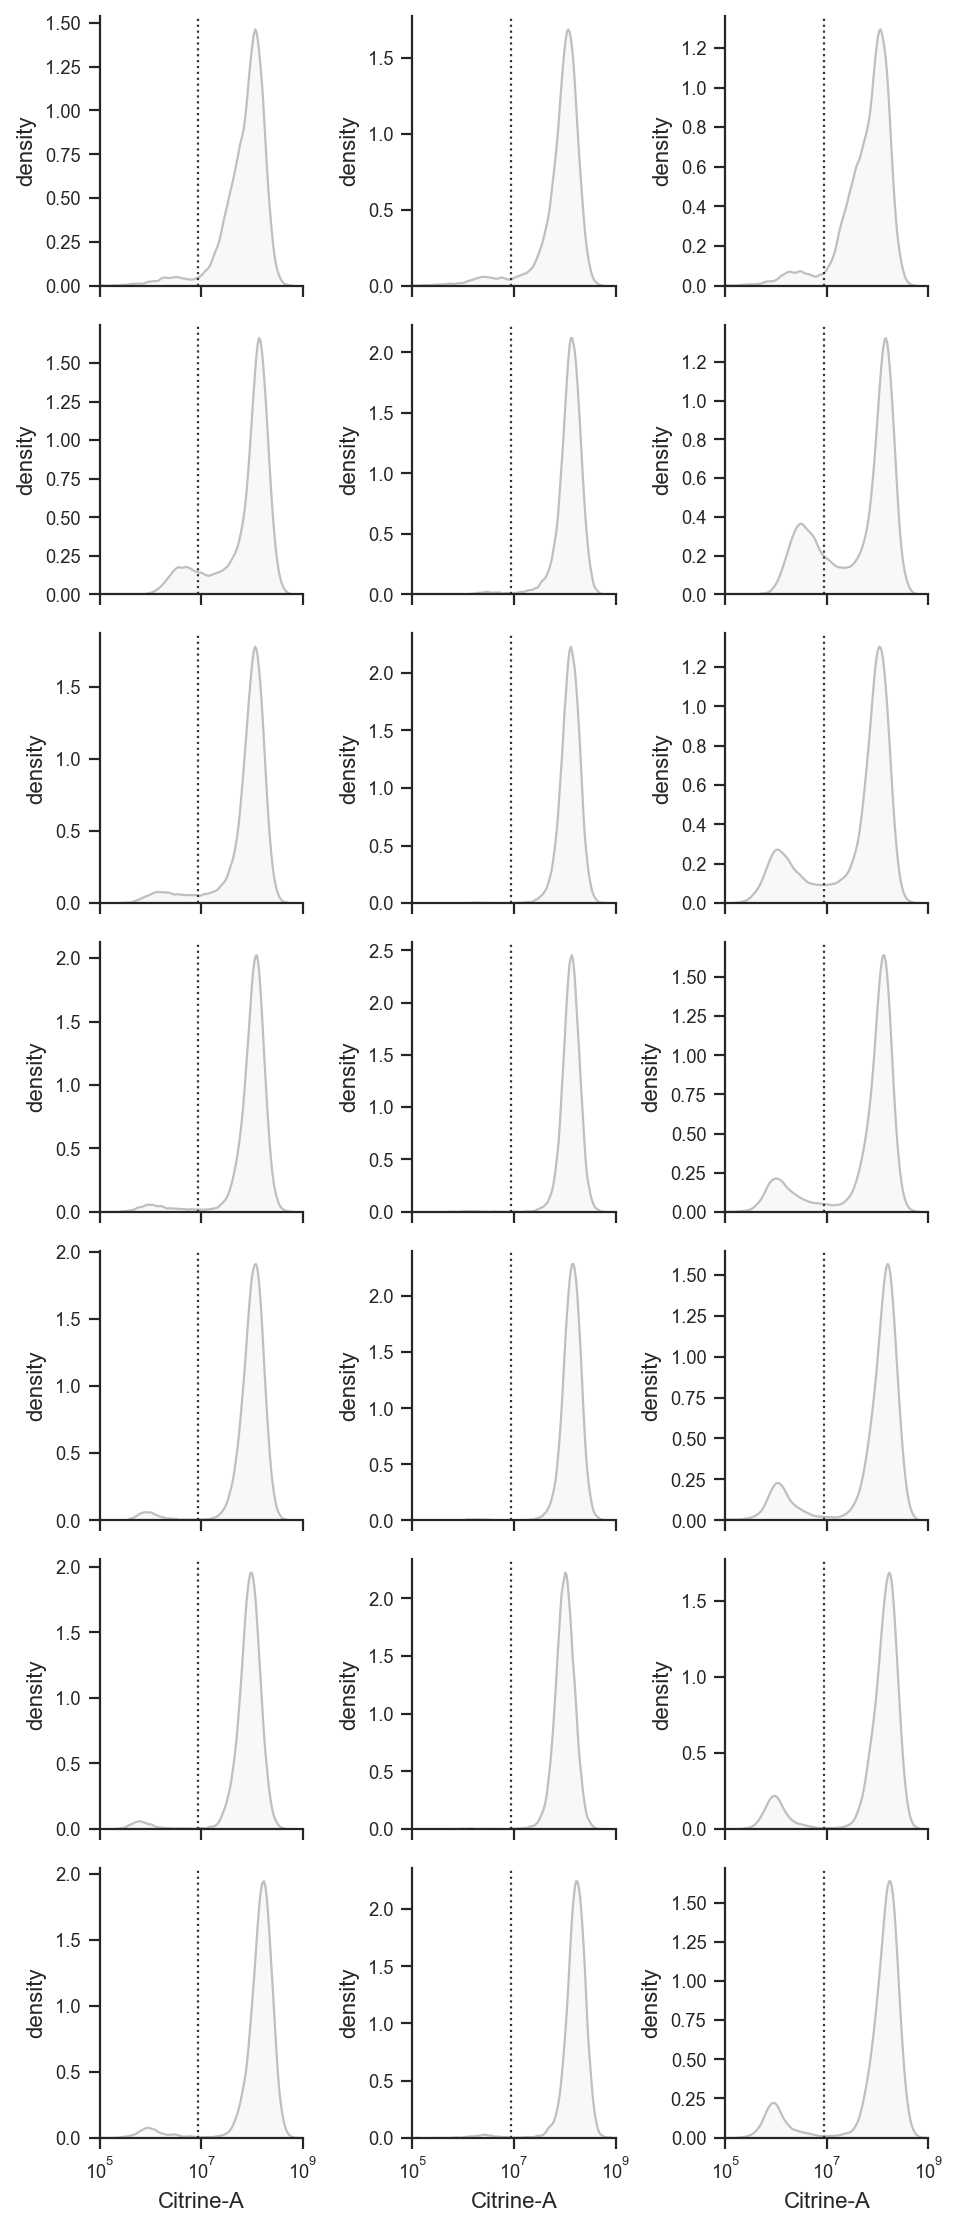

In [ ]:
# plot citrine for a given day
citrine_threshold = 8.8e6
# citrine_threshold = 20.0e6
# Set your custom color palette
colors = ["#bfbfbf","#dba468"]
sns.set_palette(sns.color_palette(colors))

data = df#[(df['day'] == 5)]
f = sns.FacetGrid(
    data = data,
    col='target',
    col_order=targetList,
    row='day',
    row_order=dayList,
    hue='rep',
    hue_order=repList,
    sharey = False,
    height = 2,
    aspect = 1,
    margin_titles = False,
)

for ax in f.axes.flat: # zip(f.axes.flat, repList): # # ax, title in zip(f.axes.flat, targetList):
    ax.set_xlabel('Citrine-A', size = 10)
    ax.set_ylabel('density', size = 10)
    ax.set_xlim([1e5, 10e8])
    # ax.set_ylim([0, 0.2])
    ax.tick_params(axis='both',which='both',width=1, length=5)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)

# f.map(sns.kdeplot, 'Citrine-A', hue='rep', og_scale = True, bw_adjust = 0.6, fill=True, alpha=0.1, linewidth=1)
f.map_dataframe(sns.kdeplot, x='Citrine-A', common_norm=False, multiple='layer',
                log_scale=True, bw_adjust=0.6, fill=True, alpha=0.1, linewidth=1, palette=sns.color_palette(colors))
f.map(plt.axvline, x=citrine_threshold, ls=':', color='#333333', linewidth=1)

f.set_titles('')
# f.set(yticks = [], ylabel = '')
# f.despine(left=True)
plt.tight_layout()
# plt.savefig(f'TFR001assoc_Citrine_timecourse_KRAB.pdf', dpi = 300)

## calculate silenced fraction

In [ ]:
citrine_threshold = 8.8e6

sil_fracs = np.empty((len(targetList), len(dayList), len(repList))) * np.nan

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dy, day in enumerate(dayList):
        dataC = dataA[dataA['day'] == day]
        for rp, rep in enumerate(repList):
            data = dataC[dataC['rep'] == rep]
            all = len(data)
            if all > 0:
                citrine_off = len(data[(data["Citrine-A"] < citrine_threshold)])
                sil_fracs[lb, dy, rp] = citrine_off/all

sil_fracs = np.sqrt(sil_fracs/maxBR)
sil_fracs_avg = np.nanmean(sil_fracs,axis=2)

In [ ]:
sil_fracs[1:,:,:]/sil_fracs[0:1,:,:]

array([[[1.05364396, 1.10467979, 0.97142885],
        [0.37917926, 0.58812606, 0.62129482],
        [0.26476134, 0.33834395, 0.32538283],
        [0.37634774, 0.4609562 , 0.62894193],
        [0.48753938, 0.59866013, 0.66785308],
        [0.38546438, 0.44791712, 0.5521792 ],
        [0.58216359, 0.56162974, 0.59839898]],

       [[1.16845926, 1.02606916, 0.96991059],
        [1.48332441, 1.36474794, 1.33969412],
        [1.72780628, 1.54459019, 1.5697388 ],
        [1.85558878, 1.52451262, 1.59413643],
        [1.94828252, 1.5297438 , 1.46600277],
        [1.83258004, 1.40121761, 1.55894058],
        [1.59068361, 1.37139474, 1.55601002]]])

In [ ]:
ZE5rawdatapath = '/Users/tfuji/Library/CloudStorage/GoogleDrive-tfuji@stanford.edu/My Drive/flow_analysis/rawdata_dCas12a/'
with open(ZE5rawdatapath+'ODR013_dCas12aKRAB_OFFfrac.npy', 'wb') as f:
    np.save(f, sil_fracs, allow_pickle=False)

# plot silenced frac

In [ ]:
dayList

[0, 0, 0, 3, 5, 7, 9, 12, 15, 18]

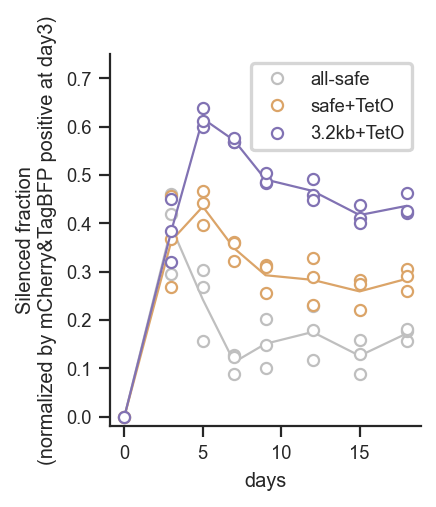

In [ ]:
colors = ["#bfbfbf","#dba468","m"]
targetlabels = ['all-safe', 'safe+TetO', '3.2kb+TetO']
fig = plt.figure(figsize = (2.8, 3))
# plt.axvline(x=5,linestyle='--',color='k', zorder=0, linewidth=1)
notreat_val = 0

time_points = dayList.copy()
time_points.insert(0, 0)
for id, target in enumerate(targetList):
    avgtimecourse = sil_fracs_avg[id,:]
    avgtimecourse = np.insert(avgtimecourse, 0, notreat_val)
    plt.plot(time_points, avgtimecourse, color=colors[id], linewidth=1, label=targetlabels[id])
    for it, timepoint in enumerate(time_points):
        if timepoint > 0:
            reppoints = sil_fracs[id,it-1,:]
            plt.plot(np.tile(timepoint,3), reppoints, marker='o', color=colors[id], markeredgewidth=1,
                    markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)
    plt.plot(0, avgtimecourse[0], marker='o', color=colors[id], markeredgewidth=1,
            markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)


ax = plt.gca()
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
plt.ylim([-0.02, 0.75])
plt.xlabel('days')
plt.ylabel('Silenced fraction\n(normalized by mCherry&TagBFP positive at day3)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # To avoid duplicate labels in legend
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()
# fig.savefig('ODR013_3p2kb_timecourse_Citrine.pdf', dpi = 300)

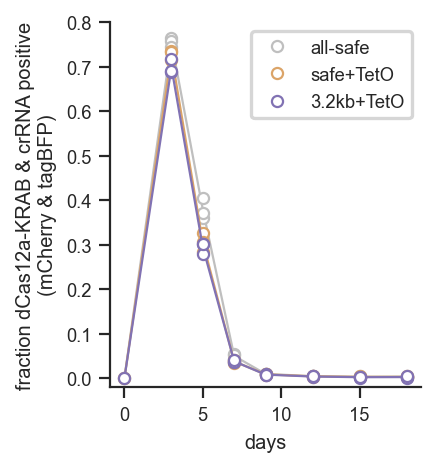

In [ ]:
colors = ["#bfbfbf","#dba468","m"]
targetlabels = ['all-safe', 'safe+TetO', '3.2kb+TetO']
fig = plt.figure(figsize = (2.8, 3))
# plt.axvline(x=5,linestyle='--',color='k', zorder=0, linewidth=1)
notreat_val = 0

time_points = dayList.copy()
time_points.insert(0, 0)
for id, target in enumerate(targetList):
    avgtimecourse = BR_fracs_avg[id,:]
    avgtimecourse = np.insert(avgtimecourse, 0, notreat_val)
    plt.plot(time_points, avgtimecourse, color=colors[id], linewidth=1, label=targetlabels[id])
    for it, timepoint in enumerate(time_points):
        if timepoint > 0:
            reppoints = BR_fracs[id,it-1,:]
            plt.plot(np.tile(timepoint,3), reppoints, marker='o', color=colors[id], markeredgewidth=1,
                    markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)
    plt.plot(0, avgtimecourse[0], marker='o', color=colors[id], markeredgewidth=1,
            markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)


ax = plt.gca()
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
plt.ylim([-0.02, 0.8])
plt.xlabel('days')
plt.ylabel('fraction dCas12a-KRAB & crRNA positive\n(mCherry & tagBFP)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # To avoid duplicate labels in legend
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()
# fig.savefig('ODR013_3p2kb_timecourse_delivered.pdf', dpi = 300)

In [ ]:
for i in range(dat.shape[0]):
    # print(scipy.stats.ranksums(dat[1,:], dat[i,:]).pvalue)
    print(scipy.stats.ttest_ind(dat[1,:], dat[i,:], equal_var=False).pvalue)

0.0037819127140375536
1.0
0.07760960774467185
0.04734029480192931
0.5423978707616884
0.08660060300328078
0.02811401393794581
0.3355852836940027
0.0015174893130471688
0.00826556657286524
0.027746700364625117
0.021880083209210095


In [ ]:
np.max(np.std(dat, axis=1))/np.min(np.std(dat, axis=1))

8.687514698682778

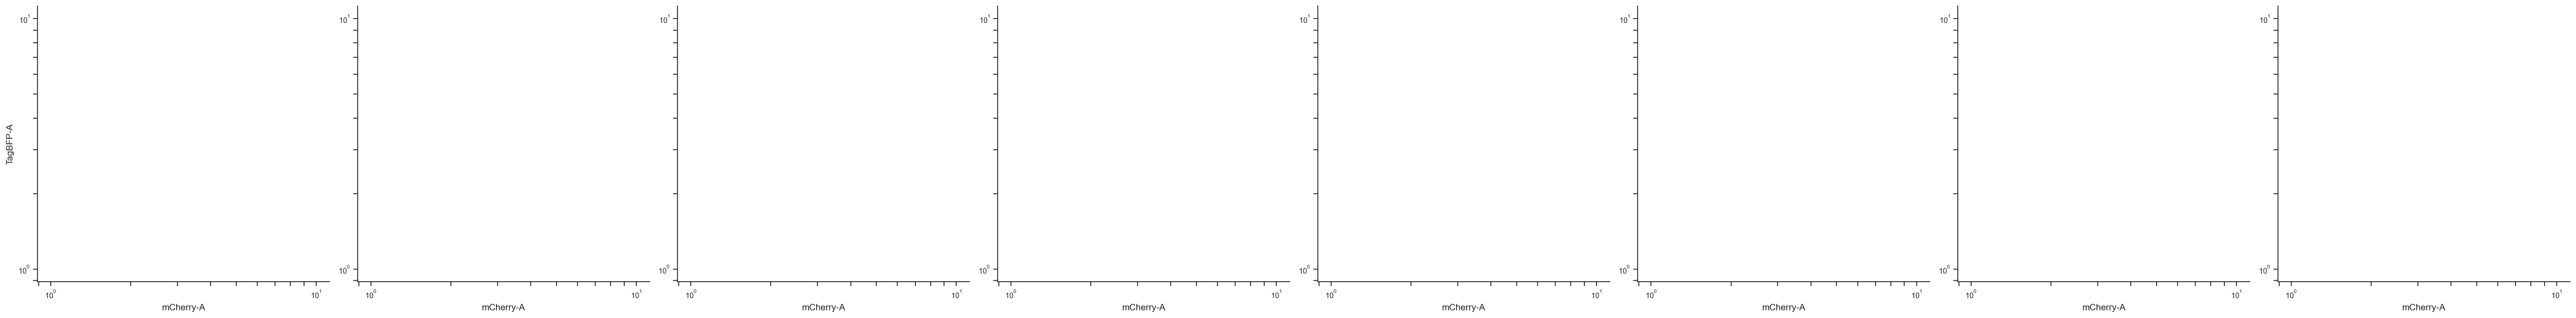

In [16]:
# plot citrine for a given day
mcherry_threshold = 3.0e6
bfp_threshold = 2.0e6
# Set your custom color palette
colors = ["#dba468"]
sns.set_palette(sns.color_palette(colors))

data = df[(df['target'] == 'B9-A10array') & (df['rep'] == 1)]
f = sns.FacetGrid(
    data = data,
    col='day',
    col_order=dayList,
    # col='target',
    # col_order=['B9-A10array'], # targetList,
    # row='day',
    # row_order=dayList,
    # hue='rep',
    # hue_order=repList,
    sharey = False,
    height = 5,
    aspect = 1,
    margin_titles = False,
)

for ax in f.axes.flat: # zip(f.axes.flat, repList): # # ax, title in zip(f.axes.flat, targetList):
    ax.set_xlabel('mCherry-A', size = 10)
    ax.set_ylabel('TagBFP-A', size = 10)
    # ax.set_xlim([1e5, 10e8])
    # ax.set_ylim([0, 0.2])
    ax.tick_params(axis='both',which='both',width=1, length=5)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.set(xscale="log", yscale="log")

# f.map(sns.kdeplot, 'Citrine-A', hue='rep', og_scale = True, bw_adjust = 0.6, fill=True, alpha=0.1, linewidth=1)
f.map_dataframe(sns.scatterplot, x='mCherry-A', y='TagBFP-A', # common_norm=False, multiple='layer', log_scale=True, bw_adjust=0.6, fill=True,
                 alpha=0.002, palette=sns.color_palette(colors), size=0.1, markers=".")
f.map(plt.axvline, x=mcherry_threshold, ls=':', color='#333333', linewidth=1)
f.map(plt.axhline, y=bfp_threshold, ls=':', color='#333333', linewidth=1)

f.set_titles('')
# f.set(yticks = [], ylabel = '')
# f.despine(left=True)
plt.tight_layout()
# plt.savefig(f'TFR001assoc_Citrine_timecourse_KRAB.pdf', dpi = 300)

In [46]:
BR_fracs = np.empty((len(targetList), len(dayList), len(repList))) * np.nan

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dy, day in enumerate(dayList):
        dataC = dataA[dataA['day'] == day]
        for rp, rep in enumerate(repList):
            data = dataC[dataC['rep'] == rep]
            all = len(data)
            if all > 0:
                BR_off = len(data[(data["mCherry-A"] > mcherry_threshold) & (data["TagBFP-A"] > bfp_threshold)])
                BR_fracs[lb, dy, rp] = BR_off/all

BRfracs_d0 = BR_fracs[3,0,0]
BR_fracs = BR_fracs[0:3,1:,:]
BR_fracs_avg = np.nanmean(BR_fracs,axis=2)
maxBR = BR_fracs.copy()
maxBR[:,1:,:] = maxBR[:,0:1,:]

In [45]:
maxBR

array([[[0.7644897 , 0.7582928 , 0.74479804],
        [0.7644897 , 0.7582928 , 0.74479804],
        [0.7644897 , 0.7582928 , 0.74479804],
        [0.7644897 , 0.7582928 , 0.74479804],
        [0.7644897 , 0.7582928 , 0.74479804],
        [0.7644897 , 0.7582928 , 0.74479804],
        [0.7644897 , 0.7582928 , 0.74479804]],

       [[0.73425509, 0.73390291, 0.71398952],
        [0.73425509, 0.73390291, 0.71398952],
        [0.73425509, 0.73390291, 0.71398952],
        [0.73425509, 0.73390291, 0.71398952],
        [0.73425509, 0.73390291, 0.71398952],
        [0.73425509, 0.73390291, 0.71398952],
        [0.73425509, 0.73390291, 0.71398952]],

       [[0.7163803 , 0.68841606, 0.69050798],
        [0.7163803 , 0.68841606, 0.69050798],
        [0.7163803 , 0.68841606, 0.69050798],
        [0.7163803 , 0.68841606, 0.69050798],
        [0.7163803 , 0.68841606, 0.69050798],
        [0.7163803 , 0.68841606, 0.69050798],
        [0.7163803 , 0.68841606, 0.69050798]]])

## double normalization

In [58]:
citrine_threshold = 8.8e6

sil_fracs = np.empty((len(targetList), len(dayList), len(repList))) * np.nan

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dy, day in enumerate(dayList):
        dataC = dataA[dataA['day'] == day]
        for rp, rep in enumerate(repList):
            data = dataC[dataC['rep'] == rep]
            all = len(data)
            if all > 0:
                citrine_off = len(data[(data["Citrine-A"] < citrine_threshold)])
                sil_fracs[lb, dy, rp] = citrine_off/all

# sil_fracs = np.sqrt(sil_fracs/maxBR)
# sil_fracs_avg = np.nanmean(sil_fracs,axis=2)

# subtract silenced fraction of cells in all-safe condition
silfracs_d0 = sil_fracs[3,0,0]
sil_fracs = sil_fracs[0:3,1:,:]
sil_fracs = sil_fracs/maxBR
sil_fracs_bg = np.mean(sil_fracs[0:1,:,:],axis=2).reshape((1,7,1))
sil_fracs_bg = np.repeat(np.repeat(sil_fracs_bg,3,axis=0),3,axis=2)
sil_fracs = np.sqrt(sil_fracs - sil_fracs_bg)
sil_fracs_avg = np.nanmean(sil_fracs,axis=2)


/var/folders/c4/g2by8npx31ncl78twyry8m940000gn/T/ipykernel_45549/164302284.py:25: RuntimeWarning: invalid value encountered in sqrt


In [64]:
time_points

[0, 3, 5, 7, 9, 12, 15, 18]

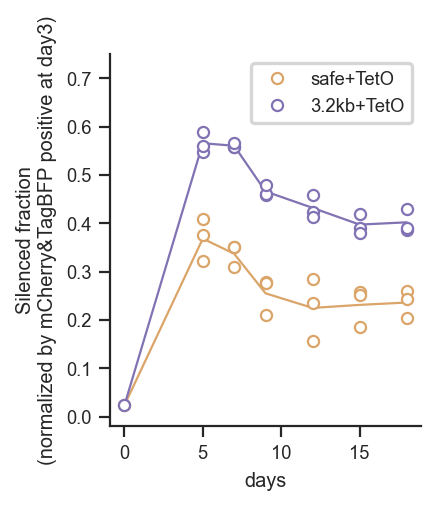

In [66]:
colors = ["#bfbfbf","#dba468","m"]
targetlabels = ['all-safe', 'safe+TetO', '3.2kb+TetO']
fig = plt.figure(figsize = (2.8, 3))
# plt.axvline(x=5,linestyle='--',color='k', zorder=0, linewidth=1)
notreat_val = silfracs_d0

time_points = dayList.copy()
time_points = time_points[1:]
time_points[0] = 0
for id, target in enumerate(targetList):
    if id > 0 and id < 3:
        avgtimecourse = sil_fracs_avg[id,1:]
        avgtimecourse = np.insert(avgtimecourse, 0, notreat_val)
        plt.plot(time_points, avgtimecourse, color=colors[id], linewidth=1, label=targetlabels[id])
        for it, timepoint in enumerate(time_points):
            if timepoint > 0:
                reppoints = sil_fracs[id,it,:]
                plt.plot(np.tile(timepoint,3), reppoints, marker='o', color=colors[id], markeredgewidth=1,
                        markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)
        plt.plot(0, avgtimecourse[0], marker='o', color=colors[id], markeredgewidth=1,
                markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)


ax = plt.gca()
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
plt.ylim([-0.02, 0.75])
plt.xlabel('days')
plt.ylabel('Silenced fraction\n(normalized by mCherry&TagBFP positive at day3)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # To avoid duplicate labels in legend
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()
# fig.savefig('ODR013_3p2kb_timecourse_Citrine_doublenorm.pdf', dpi = 300)

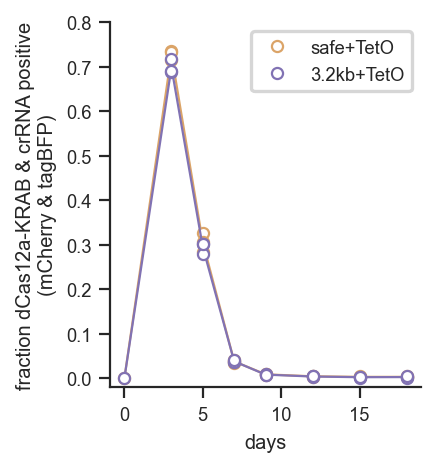

In [70]:
colors = ["#bfbfbf","#dba468","m"]
targetlabels = ['all-safe', 'safe+TetO', '3.2kb+TetO']
fig = plt.figure(figsize = (2.8, 3))
# plt.axvline(x=5,linestyle='--',color='k', zorder=0, linewidth=1)
notreat_val = BRfracs_d0

time_points = dayList.copy()
for id, target in enumerate(targetList):
    if id > 0 and id < 3:
        avgtimecourse = BR_fracs_avg[id,:]
        avgtimecourse = np.insert(avgtimecourse, 0, notreat_val)
        plt.plot(time_points, avgtimecourse, color=colors[id], linewidth=1, label=targetlabels[id])
        for it, timepoint in enumerate(time_points):
            if timepoint > 0:
                reppoints = BR_fracs[id,it-1,:]
                plt.plot(np.tile(timepoint,3), reppoints, marker='o', color=colors[id], markeredgewidth=1,
                        markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)
        plt.plot(0, avgtimecourse[0], marker='o', color=colors[id], markeredgewidth=1,
                markerfacecolor='white', markeredgecolor=colors[id], linewidth=0, label=targetlabels[id], markersize=5)


ax = plt.gca()
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
plt.ylim([-0.02, 0.8])
plt.xlabel('days')
plt.ylabel('fraction dCas12a-KRAB & crRNA positive\n(mCherry & tagBFP)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # To avoid duplicate labels in legend
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()
# fig.savefig('ODR013_3p2kb_timecourse_delivered_no-all-safe.pdf', dpi = 300)